# get_gdps

This routine grabs the latest Global Deterministic Prediction System (GDPS) model data from MSC Datamart and outputs png plots into designated product folders for each ACMWF product.

**Datamart:**

https://eccc-msc.github.io/open-data/msc-data/nwp_gdps/readme_gdps-datamart_en/#levels

https://dd.weather.gc.ca/model_gem_global/

**Outputs:**

Mountain Weather Forecast -> *500 mbar, Surface* -> ```"mwf500"```, ```"mwfsurf"```-> TCDC SFC_0,
                                                                                      PRATE SFC_0,
                                                                                      HGT ISBL_500
                                                                                      HGT ISBL_1000

Temperatures -> *1500m 0400, 1500m 1600* -> ```"temp1504"```, ```"temp1516"``` TMP ISBL_850
                                                                               TMP TGL_2
                                                                               TMP ISBL_1015
                                                                               TMP ISBL_1000
                                                                               TMP ISBL_985
                                                                               TMP ISBL_970
                                                                               TMP ISBL_950
                                                                               TMP ISBL_925
                                                                               TMP ISBL_900
                                                                               TMP ISBL_875
                                                                               TMP ISBL_850
                                                                               TMP ISBL_800
                                                                               TMP ISBL_750
                                                                               TMP ISBL_700
                                                                               TMP ISBL_650
                                                                               TMP ISBL_600
                                                                               
                                                                               

Surface Maps -> *0-144 Hours* -> ```"surf"``` TCDC SFC_0
                                              PRATE SFC_0
                                              HGT SFC_0

500 mbar & Precipitable Water -> *500 mbar, Precipitable Water* ```"mbar500"```, ```"pwat"``` ??? 500mb winds?

**Maintenance:**

For bug reports, suggestions, inquiries, contact Andrew.Loeppky@gmail.com

In [1]:
from herbie import Herbie
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
# configure text to match AC style
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "heavy"
from toolbox import EasyMap, pc
import cartopy.crs as ccrs
import cartopy.feature as feature
import pandas as pd

from matplotlib.patches import Rectangle
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pytz
import os, shutil
import json

 ╭─▌▌Herbie─────────────────────────────────────────────╮
 │ WARNING: Unable to create config file               │
 │      /Users/andrew/.config/herbie/config.toml        │
 │ Herbie will use standard default settings.           │
 │ Consider setting env variable HERBIE_CONFIG_PATH.    │
 ╰──────────────────────────────────────────────────────╯



In [2]:
# time of last model run (0Z and 12Z)
now = pd.Timestamp.utcnow().floor("24h").tz_localize(None)

# config determines the directories in which to save each graphic
with open("..//config/gdps_config.json") as f:
    config = json.load(f)

# 7 day run (144 hours) with 3 hr spacing
tstep = range(3,148,3)
tstep = range(3,24,3)


# heights to pull geopotentials
hgt = ["ISBL_1000",
       "ISBL_500"
      ]

In [3]:
def clear_directory(path):
    """
    clears all files in a directory
    """
    for name in os.listdir(path):
        full_path = os.path.join(path, name)
        if os.path.isdir(full_path):
            shutil.rmtree(full_path)
        else:
            os.remove(full_path)
    return None

In [4]:
def get_var(fxx, var, lev):
    """
    helper function to initialize herbie objects in a list comp
    """
    ds = Herbie(
            now,
            model="gdps",
            fxx=fxx,
            variable=var,
            level=lev,
        ).xarray()

    # if the variable name is unknown, assign it
    if "unknown" in ds:
        ds = ds.rename({"unknown":var})
    
    return ds

In [5]:
def plot_cities(ax):
    """
    plots and labels cities on map based on JSON file path input 
    """
    with open("../config/cities.json", "r") as f:
        cities = pd.DataFrame.from_dict(json.load(f), orient="index", columns=["Latitude", "Longitude"])

        
    ax.scatter(x=cities.Longitude, 
               y=cities.Latitude,
               color="yellow",
               edgecolor="black",
               transform=ccrs.PlateCarree()
             )
    for index, row in cities.iterrows():
        ax.text(row.Longitude,
                row.Latitude + 0.1,
                index,
                transform=ccrs.PlateCarree(),
                ha="center",
                va="bottom",
                alpha=0.7,
                color="white"
               )

    return None

In [6]:
def plot_500(ds):
    """
    plots the 500mb figure for the MWF and 500mb pages
    """
    # make a figure
    fig = plt.figure(figsize=(15,15))
    fig.tight_layout()
    ax = fig.add_subplot(1, 1, 1, 
                         position=(0,0,1,1), 
                         projection=ccrs.LambertConformal(central_longitude=-150, central_latitude=39.0,))
    ax.set_extent([-170, -117, 40, 63])

    # basemap
    ax.add_feature(feature.LAND)
    ax.add_feature(feature.STATES)
    ax.add_feature(feature.OCEAN)
    ax.add_feature(feature.COASTLINE)

    # plot height contours
    ht = ax.contour(
        ds.longitude,
        ds.latitude,
        ds.gh.loc[{"isobaricInhPa":500}],
        colors="k",
        transform=pc,
        levels=range(0, 6000, 50),
    )
    ax.clabel(ht, inline=True, fontsize=9)

    # plot thickness contours
    th_cmap = mpl.colors.ListedColormap(['pink',
                                         'blue',
                                         'orange',
                                        ])
    th_bounds = [4800, 5100, 5400, 5700]
    th_norm = mpl.colors.BoundaryNorm(th_bounds, th_cmap.N)
    ht = ax.contour(
        ds.longitude,
        ds.latitude,
        ds.thick,
        cmap=th_cmap, 
        norm=th_norm,
        linestyles="dashed",
        transform=pc,
        levels=range(4000, 6000, 60),
    )
    ax.clabel(ht, inline=True, fontsize=9)

    # plot cloud cover
    cc_cmap = mpl.colors.ListedColormap(['#DCDCDC',
                                         '#808080'])
    cc_bounds = [60, 80, 100]
    cc_norm = mpl.colors.BoundaryNorm(cc_bounds, cc_cmap.N)
    cc = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds.TCDC.where(ds.TCDC >= 60),
        cmap=cc_cmap,
        norm=cc_norm,
        antialiased=True,
        transform=pc,
    )

    # plot precip rate
    pr_cmap = mpl.colors.ListedColormap(['#90EE90',
                                         '#ADFF2F', 
                                         '#3CB371', 
                                         '#2E8B57', 
                                         '#FFFF00',
                                         '#FFA500', 
                                         '#B22222', 
                                         '#8B008B'])
    pr_bounds = [1, 2, 5, 10, 20, 30, 50, 75, 100]
    pr_norm = mpl.colors.BoundaryNorm(pr_bounds, pr_cmap.N)
    pr = ax.pcolormesh(
         ds.longitude,
         ds.latitude,
         ds.prate.where(ds.prate >= 1),
         cmap=pr_cmap,
         norm=pr_norm,
         antialiased=True,
         transform=pc,
    )

    # shade out legend regions, AC style
    ax.add_patch(Rectangle((0, 0), 0.12, 0.85, transform=ax.transAxes, color="steelblue", alpha=0.8))
    ax.add_patch(Rectangle((0, 0.85), 1, 1, transform=ax.transAxes, color="steelblue", alpha=0.8))

    # precip colorbar
    fig.text(0.121, 0.649, "6hr Pcpn", color="black", size=10)
    fig.text(0.12, 0.65, "6hr Pcpn", color="white", size=10)
    
    fig.text(0.121, 0.639, "(mm)", color="black", size=10)
    fig.text(0.12, 0.64, "(mm)", color="white", size=10)
    
    pr_cbar = fig.colorbar(
                            pr,
                            cmap=pr_cmap, 
                            norm=pr_norm,
                            ax=ax,
                            spacing='uniform',
                            shrink=0.25,
                            location="left",
                            aspect=10,
                            anchor=(0.15,0.55),
                            pad=-0.15
                           )
    pr_cbar.ax.tick_params(labelsize=10, 
                           labelcolor="white", 
                           length=0, 
                           labelright=True,
                           labelleft=False,
                          ) 

    # cloud cover colorbar
    fig.text(0.121, 0.399, "Cloud Cover", color="black", size=10)
    fig.text(0.12, 0.40, "Cloud Cover", color="white", size=10)
    
    fig.text(0.121, 0.389, "(%)", color="black", size=10)
    fig.text(0.12, 0.39, "(%)", color="white", size=10)
    
    
    cc_cbar = fig.colorbar(
                            cc,
                            cmap=cc_cmap, 
                            norm=cc_norm,
                            ax=ax,
                            spacing='uniform',
                            shrink=0.125,
                            location="left",
                            aspect=5,
                            anchor=(0.15,0.25),
                            pad=-0.18
                           )
    cc_cbar.ax.tick_params(labelsize=10, 
                           labelcolor="white", 
                           length=0, 
                           labelright=True,
                           labelleft=False,
                          ) 

    # timestamps
    the_date = pd.Timestamp(ds.valid_time.values).tz_localize('UTC').tz_convert('America/Vancouver')
    fmt_date = the_date.strftime('%a. %m-%d-%y \n%H:%M %p')
    fig.text(0.501, 0.689, fmt_date, color="black", size=20)
    fig.text(0.5, 0.69, fmt_date, color="white", size=20)
    
    fig.text(0.121, 0.259, f"{ds.model.upper()} {pd.Timestamp(ds.time.values).strftime("%H")} Z", color="black", size=10)
    fig.text(0.12, 0.26, f"{ds.model.upper()} {pd.Timestamp(ds.time.values).strftime("%H")} Z", color="white", size=10)
    
    # title
    fig.text(0.351, 0.689, '500 mb\nHeight', color="black", size=20)
    fig.text(0.35, 0.69, '500 mb\nHeight', color="white", size=20)
    
    
    # save and close the figure
    fig.savefig(os.path.join(config["plots"]["mwf500"], f"mwf_{ds.model}_{now.strftime('%Y_%_h_%d')}_{now.strftime('%H')}Z_P{fxx}"))
    fig.savefig(os.path.join(config["plots"]["500mb"], f"500mb_{ds.model}_{now.strftime('%Y_%_h_%d')}_{now.strftime('%H')}Z_P{fxx}"))
    fig.clf()

    return None

In [7]:
def plot_surf(ds):
    """
    plots the surface figure for mwf day 3-4, surface 0-144h
    """
    # make a figure
    fig = plt.figure(figsize=(15,15))
    fig.tight_layout()
    ax = fig.add_subplot(1, 1, 1, 
                     position=(0,0,1,1), 
                     projection=ccrs.LambertConformal(central_longitude=-150, central_latitude=39.0,))
    ax.set_extent([-170, -117, 40, 63])

    # basemap
    ax.add_feature(feature.LAND)
    ax.add_feature(feature.STATES)
    ax.add_feature(feature.OCEAN)
    ax.add_feature(feature.COASTLINE)

    # plot height contours
    ht = ax.contour(
    ds.longitude,
    ds.latitude,
    ds.prmsl,
    colors="k",
    transform=pc,
    levels=range(900, 1100, 4),
    )
    ax.clabel(ht, inline=True, fontsize=9)

    # plot thickness contours
    th_cmap = mpl.colors.ListedColormap(['pink',
                                     'blue',
                                     'orange',
                                    ])
    th_bounds = [4800, 5100, 5400, 5700]
    th_norm = mpl.colors.BoundaryNorm(th_bounds, th_cmap.N)
    ht = ax.contour(
    ds.longitude,
    ds.latitude,
    ds.thick,
    cmap=th_cmap, 
    norm=th_norm,
    linestyles="dashed",
    transform=pc,
    levels=range(4000, 6000, 60),
    )
    ax.clabel(ht, inline=True, fontsize=9)

    # plot cloud cover
    cc_cmap = mpl.colors.ListedColormap(['#DCDCDC',
                                     '#808080'])
    cc_bounds = [60, 80, 100]
    cc_norm = mpl.colors.BoundaryNorm(cc_bounds, cc_cmap.N)
    cc = ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.TCDC.where(ds.TCDC >= 60),
    cmap=cc_cmap,
    norm=cc_norm,
    antialiased=True,
    transform=pc,
    )

    # plot precip rate
    pr_cmap = mpl.colors.ListedColormap(['#90EE90',
                                     '#ADFF2F', 
                                     '#3CB371', 
                                     '#2E8B57', 
                                     '#FFFF00',
                                     '#FFA500', 
                                     '#B22222', 
                                     '#8B008B'])
    pr_bounds = [1, 2, 5, 10, 20, 30, 50, 75, 100]
    pr_norm = mpl.colors.BoundaryNorm(pr_bounds, pr_cmap.N)
    pr = ax.pcolormesh(
     ds.longitude,
     ds.latitude,
     ds.prate.where(ds.prate >= 1),
     cmap=pr_cmap,
     norm=pr_norm,
     antialiased=True,
     transform=pc,
    )

    # shade out legend regions, AC style
    ax.add_patch(Rectangle((0, 0), 0.12, 0.85, transform=ax.transAxes, color="steelblue", alpha=0.8))
    ax.add_patch(Rectangle((0, 0.85), 1, 1, transform=ax.transAxes, color="steelblue", alpha=0.8))

    # precip colorbar
    fig.text(0.121, 0.649, "6hr Pcpn", color="black", size=10)
    fig.text(0.12, 0.65, "6hr Pcpn", color="white", size=10)

    fig.text(0.121, 0.639, "(mm)", color="black", size=10)
    fig.text(0.12, 0.64, "(mm)", color="white", size=10)

    pr_cbar = fig.colorbar(
                        pr,
                        cmap=pr_cmap, 
                        norm=pr_norm,
                        ax=ax,
                        spacing='uniform',
                        shrink=0.25,
                        location="left",
                        aspect=10,
                        anchor=(0.15,0.55),
                        pad=-0.15
                       )
    pr_cbar.ax.tick_params(labelsize=10, 
                       labelcolor="white", 
                       length=0, 
                       labelright=True,
                       labelleft=False,
                      ) 

    # cloud cover colorbar
    fig.text(0.121, 0.399, "Cloud Cover", color="black", size=10)
    fig.text(0.12, 0.40, "Cloud Cover", color="white", size=10)

    fig.text(0.121, 0.389, "(%)", color="black", size=10)
    fig.text(0.12, 0.39, "(%)", color="white", size=10)

    cc_cbar = fig.colorbar(
                        cc,
                        cmap=cc_cmap, 
                        norm=cc_norm,
                        ax=ax,
                        spacing='uniform',
                        shrink=0.125,
                        location="left",
                        aspect=5,
                        anchor=(0.15,0.25),
                        pad=-0.18
                       )
    cc_cbar.ax.tick_params(labelsize=10, 
                       labelcolor="white", 
                       length=0, 
                       labelright=True,
                       labelleft=False,
                      ) 

    # timestamps
    the_date = pd.Timestamp(ds.valid_time.values).tz_localize('UTC').tz_convert('America/Vancouver')
    fmt_date = the_date.strftime('%a. %m-%d-%y \n%H:%M %p')

    fig.text(0.501, 0.689, fmt_date, color="black", size=20)
    fig.text(0.5, 0.69, fmt_date, color="white", size=20)
    fig.text(0.121, 0.259, f"{ds.model.upper()} {pd.Timestamp(ds.time.values).strftime("%H")} Z", color="black", size=10)
    fig.text(0.12, 0.26, f"{ds.model.upper()} {pd.Timestamp(ds.time.values).strftime("%H")} Z", color="white", size=10)

    # title
    fig.text(0.351, 0.689, 'Surface', color="black", size=20)
    fig.text(0.35, 0.69, 'Surface', color="white", size=20)
    
    # save and close the figure
    if fxx >= 72: # only save mwf maps for day 3+
        fig.savefig(os.path.join(config["plots"]["mwfsurf"], f"surf_{ds.model}_{now.strftime('%Y_%_h_%d')}_{now.strftime('%H')}Z_P{fxx}"))
    fig.savefig(os.path.join(config["plots"]["surf"], f"surf_{ds.model}_{now.strftime('%Y_%_h_%d')}_{now.strftime('%H')}Z_P{fxx}"))
    fig.clf()
    
    return None

In [8]:
def plot_temps(ds):
    """
    plots 1500m temperatures, saves at 0400 and 1600 Pacific
    """
    # make a figure
    fig = plt.figure(figsize=(15,15))
    fig.tight_layout()
    ax = fig.add_subplot(1, 1, 1, 
                         position=(0,0,1,1), 
                         projection=ccrs.LambertConformal(central_longitude=-123, central_latitude=54.0,))
    ax.set_extent([-140, -110, 46, 65])

    # basemap
    ax.add_feature(feature.LAKES)
    ax.add_feature(feature.STATES)
    ax.add_feature(feature.RIVERS)
    ax.add_feature(feature.COASTLINE)

    # plot 850mb temps
    t_cmap = mpl.colors.ListedColormap(['#FFFAFA',
                                        '#C0C0C0',
                                        '#4B0082',
                                        '#8B008B',
                                        '#9400D3',
                                        '#9370DB',
                                        '#0000CD',
                                        '#1E90FF',
                                        '#00BFFF',
                                        '#F0E68C',
                                        '#FFFF00',
                                        '#FFA500',
                                        '#FF4500',
                                        '#d62728',
                                        '#FF69B4',
                                        '#800000',
                                        '#000000'
                                       ])
    t_bounds = [-40, -35, -30, -25, -20, -15, -10, -5, -1, 1, 5, 10, 15, 20, 25, 30, 35, 40]
    t_norm = mpl.colors.BoundaryNorm(t_bounds, t_cmap.N)
    t = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds.t,
        cmap=t_cmap,
        norm=t_norm,
        antialiased=True,
        transform=pc,
    )

    # shade out legend regions, AC style
    ax.add_patch(Rectangle((0, 0), 0.12, 0.85, transform=ax.transAxes, color="steelblue", alpha=0.8))
    ax.add_patch(Rectangle((0, 0.85), 1, 1, transform=ax.transAxes, color="steelblue", alpha=0.8))

    # 1500m temp colorbar
    fig.text(0.141, 0.689, "($^o$C)", color="black", size=10)
    fig.text(0.14, 0.69, "($^o$C)", color="white", size=10)

    t_cbar = fig.colorbar(
                            t,
                            cmap=t_cmap, 
                            norm=t_norm,
                            ax=ax,
                            spacing='uniform',
                            shrink=0.6,
                            location="left",
                            aspect=20,
                            anchor=(0.15,0.25),
                            pad=-0.18
                           )
    t_cbar.ax.set_yticks(t_bounds)
    t_cbar.ax.tick_params(labelsize=10, 
                           labelcolor="white", 
                           length=0, 
                           labelright=True,
                           labelleft=False,
                          ) 

    # cities
    plot_cities(ax)
    
    # timestamps
    the_date = pd.Timestamp(ds.valid_time.values).tz_localize('UTC').tz_convert('America/Vancouver')
    fmt_date = the_date.strftime('%a. %m-%d-%y \n%H:%M %p')

    fig.text(0.501, 0.809, fmt_date, color="black", size=20)
    fig.text(0.5, 0.81, fmt_date, color="white", size=20)
    fig.text(0.121, 0.159, f"{ds.model.upper()} {pd.Timestamp(ds.time.values).strftime("%H")} Z", color="black", size=10)
    fig.text(0.12, 0.16, f"{ds.model.upper()} {pd.Timestamp(ds.time.values).strftime("%H")} Z", color="white", size=10)

    # title
    fig.text(0.351, 0.809, 'Temperature\n1500 meters', color="black", size=20)
    fig.text(0.35, 0.81, 'Temperature\n1500 meters', color="white", size=20)

    if the_date.hour in (4,5):
        fig.savefig(os.path.join(config["plots"]["temp1504"], f"temp1500_{ds.model}_{now.strftime('%Y_%_h_%d')}_{now.strftime('%H')}Z_P{fxx}"))
    if the_date.hour in (16,17):
        fig.savefig(os.path.join(config["plots"]["temp1516"], f"temp1500_{ds.model}_{now.strftime('%Y_%_h_%d')}_{now.strftime('%H')}Z_P{fxx}"))
    fig.clf()

In [9]:
# clear the plot folders depedent on gdps data
clear_dir = [clear_directory(file) for file in list(config["plots"].values())]
    
for fxx in tstep:
    # clear the gdps data folder
    clear_dir = [clear_directory(file) for file in list(config["data"].values())]
    
    # get all the data and merge it into one big xarray
    temp = get_var(fxx, "TMP", "ISBL_850")
    tcdc = get_var(fxx, "TCDC", "SFC_0")
    prate = get_var(fxx, "PRATE", "SFC_0")
    height = xr.concat([get_var(fxx, "HGT", h) for h in hgt], dim="isobaricInhPa")
    pres = get_var(fxx, "PRMSL", "MSL_0")
    ds = xr.merge([temp, tcdc, prate, height, pres])
    
    # slice out only the domain we care about
    ds = ds.sel(longitude=slice(-195, -97), latitude=slice(30, 73))

    # convert precip from kg/m3/s to mm/6h
    ds["prate"] *= (3600 * 6) 
    
    # convert sea level pressure to hPa
    ds["prmsl"] /= 100
    
    # convert temps from kelvin to degC
    ds["t"] -= 273.15

    # calculate 1000 - 500mb thickness
    ds["thick"] = ds.gh.loc[{"isobaricInhPa":500}] - ds.gh.loc[{"isobaricInhPa":1000}] 
    
    # make the plots
    plot_500(ds)
    plot_surf(ds)
    plot_temps(ds)

✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/gdps/20250602]


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/gdps/20250602]


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F09 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/gdps/20250602]


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F09 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F09 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F09 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F09 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F09 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F12 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/gdps/20250602]


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F12 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F12 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F12 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F12 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F12 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F15 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/gdps/20250602]


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F15 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F15 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F15 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F15 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F15 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F18 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/gdps/20250602]


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F18 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F18 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F18 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F18 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F18 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F21 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/gdps/20250602]


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F21 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F21 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F21 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F21 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-02 00:00 UTC F21 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(
/var/folders/gw/d8k1vszn7ws41z7c0209d9500000gn/T/ipykernel_59256/4284069417.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(15,15))


<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

Text(0.35, 0.81, 'Temperature\n1500 meters')

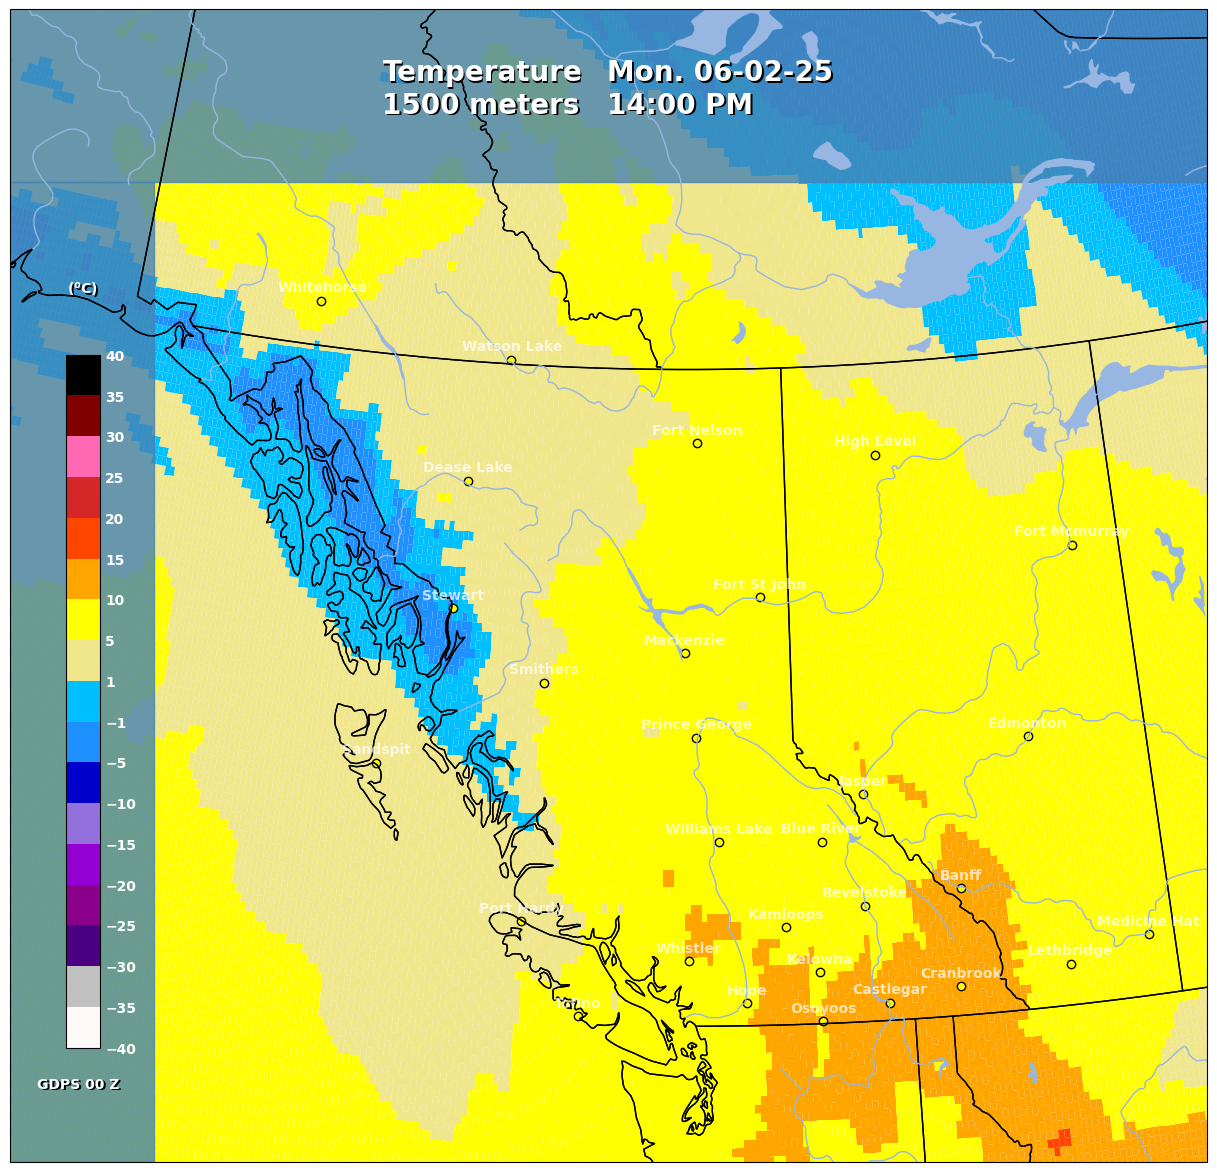

In [10]:
# make a figure
fig = plt.figure(figsize=(15,15))
fig.tight_layout()
ax = fig.add_subplot(1, 1, 1, 
                     position=(0,0,1,1), 
                     projection=ccrs.LambertConformal(central_longitude=-123, central_latitude=54.0,))
ax.set_extent([-140, -110, 46, 65])

# basemap
ax.add_feature(feature.LAKES)
ax.add_feature(feature.STATES)
ax.add_feature(feature.RIVERS)
ax.add_feature(feature.COASTLINE)

# plot 850mb temps
t_cmap = mpl.colors.ListedColormap(['#FFFAFA',
                                    '#C0C0C0',
                                    '#4B0082',
                                    '#8B008B',
                                    '#9400D3',
                                    '#9370DB',
                                    '#0000CD',
                                    '#1E90FF',
                                    '#00BFFF',
                                    '#F0E68C',
                                    '#FFFF00',
                                    '#FFA500',
                                    '#FF4500',
                                    '#d62728',
                                    '#FF69B4',
                                    '#800000',
                                    '#000000'
                                   ])
t_bounds = [-40, -35, -30, -25, -20, -15, -10, -5, -1, 1, 5, 10, 15, 20, 25, 30, 35, 40]
t_norm = mpl.colors.BoundaryNorm(t_bounds, t_cmap.N)
t = ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.t,
    cmap=t_cmap,
    norm=t_norm,
    antialiased=True,
    transform=pc,
)

# shade out legend regions, AC style
ax.add_patch(Rectangle((0, 0), 0.12, 0.85, transform=ax.transAxes, color="steelblue", alpha=0.8))
ax.add_patch(Rectangle((0, 0.85), 1, 1, transform=ax.transAxes, color="steelblue", alpha=0.8))

# 1500m temp colorbar
fig.text(0.141, 0.689, "($^o$C)", color="black", size=10)
fig.text(0.14, 0.69, "($^o$C)", color="white", size=10)

t_cbar = fig.colorbar(
                        t,
                        cmap=t_cmap, 
                        norm=t_norm,
                        ax=ax,
                        spacing='uniform',
                        shrink=0.6,
                        location="left",
                        aspect=20,
                        anchor=(0.15,0.25),
                        pad=-0.18
                       )
t_cbar.ax.set_yticks(t_bounds)
t_cbar.ax.tick_params(labelsize=10, 
                       labelcolor="white", 
                       length=0, 
                       labelright=True,
                       labelleft=False,
                      ) 

# cities
plot_cities(ax)


# timestamps
the_date = pd.Timestamp(ds.valid_time.values).tz_localize('UTC').tz_convert('America/Vancouver')
fmt_date = the_date.strftime('%a. %m-%d-%y \n%H:%M %p')

fig.text(0.501, 0.809, fmt_date, color="black", size=20)
fig.text(0.5, 0.81, fmt_date, color="white", size=20)
fig.text(0.121, 0.159, f"{ds.model.upper()} {pd.Timestamp(ds.time.values).strftime("%H")} Z", color="black", size=10)
fig.text(0.12, 0.16, f"{ds.model.upper()} {pd.Timestamp(ds.time.values).strftime("%H")} Z", color="white", size=10)

# title
fig.text(0.351, 0.809, 'Temperature\n1500 meters', color="black", size=20)
fig.text(0.35, 0.81, 'Temperature\n1500 meters', color="white", size=20)
